In [1]:
import os
import json
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from imagenet_info import imagenet_info
from IPython.core.display import display, HTML
import PIL


In [2]:
np.random.seed(3003)

In [3]:
os.environ["CUDA_VISIBLE_DIVICES"] = "9"
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)
display(HTML("<style>.container { width:98% !important;}</style>"))

In [4]:
imgnet_info = imagenet_info("map_clsloc.txt", "ILSVRC2012_validation_ground_truth.txt")

In [5]:
imgnet_info.df.head()

,net_label,label,index,name
0,0,1,n02119789,kit_fox
1,1,2,n02100735,English_setter
2,2,3,n02110185,Siberian_husky
3,3,4,n02096294,Australian_terrier
4,4,5,n02102040,English_springer


In [6]:
class train_image_dataset():
    def __init__(self, img_folder, img_size, imagenet_info, batch_size=32):
        self.img_folder = img_folder
        self.img_size = img_size
        self.batch_size = batch_size
        self.index_to_net_label = imagenet_info.index_to_net_label
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.Dataset = self._generator()
    
    def train_preprocessing_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)

        img = tf.image.resize(img, (self.img_size+32, self.img_size+32))
        crop_size = tf.random.uniform([1], minval=self.img_size-32, maxval=self.img_size+32, dtype=tf.int32)
        img = tf.image.random_crop(img , [crop_size[0], crop_size[0], 3])
        img = tf.image.resize(img, (self.img_size, self.img_size))
        img /= 255.
        return img
    
    def _generator(self):
        data_root = pathlib.Path(self.img_folder)
        all_image_path = []
        all_label = []
        all_image_libpath = [path for path in data_root.glob("./*/*")]
        random.shuffle(all_image_libpath)
        for path in all_image_libpath:
            all_image_path.append(str(path))
            all_label.append(self.index_to_net_label[path.parent.name])
        
        path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)
        image_ds = path_ds.map(self.train_preprocessing_image, num_parallel_calls=self.AUTOTUNE)
        label_ds = tf.data.Dataset.from_tensor_slices(all_label)
       
        path_image_label_ds = tf.data.Dataset.zip((path_ds, image_ds, label_ds))
        path_image_label_ds = path_image_label_ds.shuffle(buffer_size=12000).repeat().\
        batch(self.batch_size).prefetch(buffer_size=self.AUTOTUNE)
        self.data_length = len(all_image_path)
        return path_image_label_ds
    
    def __len__(self):
        return self.data_length
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return next(iter(self.Dataset))
    

In [19]:
class valid_image_dataset():
    def __init__(self, img_folder, img_size, imagenet_info, batch_size=100):
        self.img_folder = img_folder
        self.img_size = img_size
        self.batch_size = batch_size
        self.index_to_net_label = imagenet_info.index_to_net_label
        self.imgnet_info = imagenet_info
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.Dataset = self._generator()
    
    def valid_preprocessing_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (self.img_size, self.img_size))
        img /= 255.
        return img 
    
    def _generator(self):
        all_images = os.listdir(self.img_folder)
        all_images.sort()
        all_image_path = [os.path.join(self.img_folder, file) for file in all_images]
        all_label = self.imgnet_info.val_label["net_label"]
        path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)
        image_ds = path_ds.map(self.valid_preprocessing_image, num_parallel_calls=self.AUTOTUNE)
        label_ds = tf.data.Dataset.from_tensor_slices(all_label)
        path_image_label_ds = tf.data.Dataset.zip((path_ds, image_ds, label_ds))
        path_image_label_ds = path_image_label_ds.shuffle(buffer_size=12000).repeat().\
        batch(self.batch_size).prefetch(buffer_size=self.AUTOTUNE)
        self.data_length = len(all_image_path)
        return path_image_label_ds
    
    def __len__(self):
        return self.data_length
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return next(iter(self.Dataset))

In [20]:
valid_dataset = valid_image_dataset("/raid/peterchen/datasets/imagenet/2012/valid/", 256, imgnet_info)

In [21]:
x, y, z = next(iter(valid_dataset))

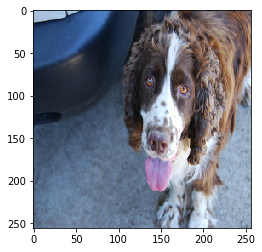

In [22]:
show_img = tf.cast(y[0] * 255, tf.uint8).numpy()
plt.imshow(show_img)

In [23]:
z[0]

<tf.Tensor: id=144, shape=(), dtype=int32, numpy=4>

In [25]:
imgnet_info.df[imgnet_info.df["net_label"]==4]

,net_label,label,index,name
4,4,5,n02102040,English_springer


In [7]:
img_folder = "/raid/peterchen/datasets/imagenet/2012/train/"
img_size = 256

In [8]:
dataset = train_image_dataset(img_folder, img_size, imgnet_info)

In [15]:
a,b ,c = next(iter(dataset))

In [16]:
a[0]

<tf.Tensor: id=103, shape=(), dtype=string, numpy=b'/raid/peterchen/datasets/imagenet/2012/train/n02666196/n02666196_14738.JPEG'>

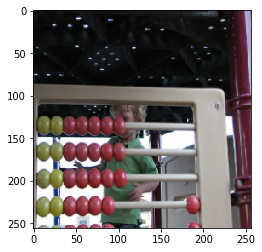

In [17]:
show_img = tf.cast(b[0] * 255, tf.uint8).numpy()
plt.imshow(show_img)

In [18]:
c[0]

<tf.Tensor: id=114, shape=(), dtype=int32, numpy=546>

In [19]:
imgnet_info.df[imgnet_info.df["net_label"]==546]

,net_label,label,index,name
546,546,547,n02666196,abacus


In [30]:
imgnet_info.net_label_to_index[861]

'n04033901'

In [25]:
a

<tf.Tensor: id=77, shape=(), dtype=string, numpy=b'/raid/peterchen/datasets/imagenet/2012/train/n02840245/n02840245_7521.JPEG'>

In [26]:
c

<tf.Tensor: id=78, shape=(), dtype=int32, numpy=834>

In [11]:
show_img = tf.cast(b * 255, tf.uint8).numpy()

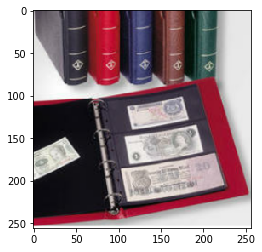

In [12]:
plt.imshow(show_img)

In [13]:
c

<tf.Tensor: id=63, shape=(), dtype=int32, numpy=834>

In [57]:
imgnet_info.df[imgnet_info.df["net_label"]==347]

,net_label,label,index,name
347,347,348,n03394916,French_horn


In [ ]:
imgnet_info.df[imgnet_info.df["index"]==180]

In [ ]:
imgnet_info.index_to_net_label["n04033901"]

In [ ]:
imgnet_info.df[imgnet_info.df["net_label"]==861]

In [3]:
class train_image_dataset():
    def __init__(self, image_path, index_path, img_size, imagenet_info):
        self.image_path = image_path
        self.index_path = index_path
        self.index_df = self._index_to_df()
        self.index_to_net_label = imagenet_info.index_to_net_label
        self.net_label_to_index = imagenet_info.net_label_to_index
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.Dataset = self._generator()
        
    def _index_to_df(self):
        with open(imagenet_label_path) as f:
            index_df = pd.DataFrame(json.load(f)).T
        index_df = index_df.rename(columns={0:"label", 1:"name"})
        return index_df
    
    def _index_label_dict(self):
        label_to_index = {}
        for i in range(len(self.index_df)):
            label = self.index_df["label"][i]
            label_to_index[label] = str(i)
        index_to_label = self.index_df.to_dict()["label"]
        return index_to_label, label_to_index
    
    def train_preprocessing_image(self, image):
        image = tf.io.read_file(image)
        image = tf.image.decode_jpeg(image, channels=3)

        image = tf.image.resize(image, (288, 288))
        crop_size = tf.random.uniform([1], minval=224, maxval=288, dtype=tf.int32)
        image = tf.image.random_crop(image , [crop_size[0], crop_size[0], 3])
        image = tf.image.resize(image, (256, 256))
        image /= 255.
        return image    
    
    def _generator(self):
        data_root = pathlib.Path(self.image_path)
        all_image_path = []
        all_label = []
        for path in data_root.glob("./*/*"):
            all_image_path.append(str(path))
            all_label.append(self.index_to_net_label[path.parent.name])
        
        path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)
        image_ds = path_ds.map(self.train_preprocessing_image, num_parallel_calls=self.AUTOTUNE)
        label_ds = tf.data.Dataset.from_tensor_slices(all_label)
       
        path_image_label_ds = tf.data.Dataset.zip((path_ds, image_ds, label_ds))
        path_image_label_ds = path_image_label_ds.shuffle(buffer_size=6000).repeat().batch(32).prefetch(buffer_size=self.AUTOTUNE)
        self.data_length = len(all_image_path)
        return path_image_label_ds
    
    def __len__(self):
        return self.data_length
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return next(iter(self.Dataset))
                    

In [6]:
imagenet_label_path = "/raid/peterchen/datasets/imagenet/2012/imagenet_class_index.json"
with open(imagenet_label_path) as f:
    imagenet_df = pd.DataFrame(json.load(f)).T

In [7]:
val_label_path = "/raid/peterchen/datasets/imagenet/2012/ILSVRC2012_validation_ground_truth.txt"
with open(val_label_path) as f:
    val_label = f.readlines()

In [10]:
map_index = "/raid/peterchen/datasets/imagenet/2012/map_clsloc.txt"
with open(map_index) as f:
    val_label = f.readlines()

In [26]:
df = pd.DataFrame(val_label, columns=["all_label"])

In [27]:
df.head()

,all_label
0,n02119789 1 kit_fox\n
1,n02100735 2 English_setter\n
2,n02110185 3 Siberian_husky\n
3,n02096294 4 Australian_terrier\n
4,n02102040 5 English_springer\n


In [54]:
df_index = df.all_label.str.split(" ").str.get(0)

In [56]:
df["index"] = df.all_label.str.split(" ").str.get(0)

In [57]:
df["label"] = df.all_label.str.split(" ").str.get(1)

In [58]:
df["name"] = df.all_label.str.split(" ").str.get(2)

In [64]:
df = df.drop("all_label", axis=1)

In [67]:
df["name"] = df["name"].str.strip("\n")

In [70]:
df["net_label"] = df["label"].astype(np.int32) -1

In [71]:
df

,index,label,name,net_label
0,n02119789,1,kit_fox,0
1,n02100735,2,English_setter,1
2,n02110185,3,Siberian_husky,2
3,n02096294,4,Australian_terrier,3
4,n02102040,5,English_springer,4
...,...,...,...,...
995,n03063599,996,coffee_mug,995
996,n04116512,997,rubber_eraser,996
997,n04325704,998,stole,997
998,n07831146,999,carbonara,998


In [14]:
df["index"] = df["index"]

KeyError: 'index'

In [11]:
val_label

['n02119789 1 kit_fox\n',
 'n02100735 2 English_setter\n',
 'n02110185 3 Siberian_husky\n',
 'n02096294 4 Australian_terrier\n',
 'n02102040 5 English_springer\n',
 'n02066245 6 grey_whale\n',
 'n02509815 7 lesser_panda\n',
 'n02124075 8 Egyptian_cat\n',
 'n02417914 9 ibex\n',
 'n02123394 10 Persian_cat\n',
 'n02125311 11 cougar\n',
 'n02423022 12 gazelle\n',
 'n02346627 13 porcupine\n',
 'n02077923 14 sea_lion\n',
 'n02110063 15 malamute\n',
 'n02447366 16 badger\n',
 'n02109047 17 Great_Dane\n',
 'n02089867 18 Walker_hound\n',
 'n02102177 19 Welsh_springer_spaniel\n',
 'n02091134 20 whippet\n',
 'n02092002 21 Scottish_deerhound\n',
 'n02071294 22 killer_whale\n',
 'n02442845 23 mink\n',
 'n02504458 24 African_elephant\n',
 'n02092339 25 Weimaraner\n',
 'n02098105 26 soft-coated_wheaten_terrier\n',
 'n02096437 27 Dandie_Dinmont\n',
 'n02114712 28 red_wolf\n',
 'n02105641 29 Old_English_sheepdog\n',
 'n02128925 30 jaguar\n',
 'n02091635 31 otterhound\n',
 'n02088466 32 bloodhound\n',
 

In [8]:
imagenet_df.head()

,0,1
0,n01440764,tench
1,n01443537,goldfish
2,n01484850,great_white_shark
3,n01491361,tiger_shark
4,n01494475,hammerhead


In [9]:
val_label

['490\n',
 '361\n',
 '171\n',
 '822\n',
 '297\n',
 '482\n',
 '13\n',
 '704\n',
 '599\n',
 '164\n',
 '649\n',
 '11\n',
 '73\n',
 '286\n',
 '554\n',
 '6\n',
 '648\n',
 '399\n',
 '749\n',
 '545\n',
 '13\n',
 '204\n',
 '318\n',
 '693\n',
 '399\n',
 '304\n',
 '102\n',
 '207\n',
 '480\n',
 '780\n',
 '644\n',
 '275\n',
 '14\n',
 '954\n',
 '249\n',
 '790\n',
 '501\n',
 '547\n',
 '809\n',
 '606\n',
 '297\n',
 '927\n',
 '424\n',
 '156\n',
 '60\n',
 '983\n',
 '256\n',
 '207\n',
 '281\n',
 '456\n',
 '413\n',
 '498\n',
 '561\n',
 '750\n',
 '182\n',
 '267\n',
 '118\n',
 '893\n',
 '597\n',
 '840\n',
 '836\n',
 '107\n',
 '647\n',
 '471\n',
 '945\n',
 '451\n',
 '214\n',
 '790\n',
 '291\n',
 '837\n',
 '707\n',
 '193\n',
 '397\n',
 '568\n',
 '401\n',
 '705\n',
 '200\n',
 '202\n',
 '31\n',
 '949\n',
 '361\n',
 '98\n',
 '709\n',
 '483\n',
 '563\n',
 '695\n',
 '122\n',
 '497\n',
 '914\n',
 '476\n',
 '102\n',
 '199\n',
 '104\n',
 '221\n',
 '138\n',
 '257\n',
 '188\n',
 '436\n',
 '229\n',
 '52\n',
 '377\n',
 

In [5]:
val_label_df = pd.DataFrame(columns=["image_label", "label"])
val_label_df["label"] = val_label
num = [i for i in range(1, 50001)]
val_label_df["image_label"] = num
val_label_df["label"] = val_label_df.label.str.strip("\n")
val_label_df["index"] = val_label_df["label"].map(index_to_label)
imagenet_df = imagenet_df.rename(columns={0:"label", 1:"name"})

NameError: name 'index_to_label' is not defined

In [ ]:
imagenet_df.head()

In [ ]:
val_label_df

In [ ]:
assert False

In [3]:
class train_image_dataset():
    def __init__(self, image_path, index_path, img_size):
        self.image_path = image_path
        self.index_path = index_path
        self.index_df = self._index_to_df()
        self.index_to_label, self.label_to_index = self._index_label_dict()
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.Dataset = self._generator()
        
    def _index_to_df(self):
        with open(imagenet_label_path) as f:
            index_df = pd.DataFrame(json.load(f)).T
        index_df = index_df.rename(columns={0:"label", 1:"name"})
        return index_df
    
    def _index_label_dict(self):
        label_to_index = {}
        for i in range(len(self.index_df)):
            label = self.index_df["label"][i]
            label_to_index[label] = str(i)
        index_to_label = self.index_df.to_dict()["label"]
        return index_to_label, label_to_index
    
    def train_preprocessing_image(self, image):
        image = tf.io.read_file(image)
        image = tf.image.decode_jpeg(image, channels=3)

        image = tf.image.resize(image, (288, 288))
        crop_size = tf.random.uniform([1], minval=224, maxval=288, dtype=tf.int32)
        image = tf.image.random_crop(image , [crop_size[0], crop_size[0], 3])
        image = tf.image.resize(image, (256, 256))
        image /= 255.
        return image    
    
    def _generator(self):
        data_root = pathlib.Path(self.image_path)
        all_image_path = []
        all_label = []
        for path in data_root.glob("./*/*"):
            all_image_path.append(str(path))
            all_label.append(self.label_to_index[path.parent.name])
        
        path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)
        image_ds = path_ds.map(self.train_preprocessing_image, num_parallel_calls=self.AUTOTUNE)
        label_ds = tf.data.Dataset.from_tensor_slices(all_label)
       
        path_image_label_ds = tf.data.Dataset.zip((path_ds, image_ds, label_ds))
        path_image_label_ds = path_image_label_ds.shuffle(buffer_size=6000).repeat().batch(32).prefetch(buffer_size=self.AUTOTUNE)
        self.data_length = len(all_image_path)
        return path_image_label_ds
    
    def __len__(self):
        return self.data_length
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return next(iter(self.Dataset))
                    

In [37]:
imagenet_label_path = "/raid/peterchen/datasets/imagenet/2012/imagenet_class_index.json"

In [38]:
val_label_path = "/raid/peterchen/datasets/imagenet/2012/ILSVRC2012_validation_ground_truth.txt"

In [39]:
with open(imagenet_label_path) as f:
    imagenet_df = pd.DataFrame(json.load(f)).T

In [40]:
with open(val_label_path) as f:
    val_label = f.readlines()

In [41]:
val_label_df = pd.DataFrame(columns=["image_label", "label"])

In [42]:
imagenet_df = imagenet_df.rename(columns={0:"label", 1:"name"})

In [43]:
label_to_index = {}
for i in range(len(imagenet_df)):
    code = imagenet_df["label"][i]
    label_to_index[code] = str(i)
index_to_label = imagenet_df.to_dict()["label"]

In [44]:
num = [i for i in range(1, 50001)]

In [45]:
val_label_df["label"] = val_label

In [46]:
val_label_df["image_label"] = num

In [47]:
val_label_df["label"] = val_label_df.label.str.strip("\n")

In [48]:
val_label_df["label"] = val_label_df["label"].astype(np.int32) -1

In [49]:
val_label_df["label"] = val_label_df["label"].astype(np.str)

In [50]:
val_label_df["index"] = val_label_df["label"].map(index_to_label)

In [64]:
imagenet_df.iloc[489]

label          n03000134
name     chainlink_fence
Name: 489, dtype: object

In [61]:
val_label_df

,image_label,label,index
0,1,489,n03000134
1,2,360,n02444819
2,3,170,n02090721
3,4,821,n04311004
4,5,296,n02134084
...,...,...,...
49995,49996,9,n01518878
49996,49997,494,n03017168
49997,49998,127,n02002556
49998,49999,847,n04389033


In [59]:
val_label_df[val_label_df["label"].astype(np.int32) == 2]

,image_label,label,index
268,269,2,n01484850
992,993,2,n01484850
1313,1314,2,n01484850
2282,2283,2,n01484850
4191,4192,2,n01484850
4966,4967,2,n01484850
5063,5064,2,n01484850
6538,6539,2,n01484850
6583,6584,2,n01484850
7217,7218,2,n01484850


In [45]:
int("001")

1

In [23]:
val_label_df.loc[0] = "aaa"

In [24]:
val_label_df

,label
0,aaa


In [20]:
val_label

['490\n',
 '361\n',
 '171\n',
 '822\n',
 '297\n',
 '482\n',
 '13\n',
 '704\n',
 '599\n',
 '164\n',
 '649\n',
 '11\n',
 '73\n',
 '286\n',
 '554\n',
 '6\n',
 '648\n',
 '399\n',
 '749\n',
 '545\n',
 '13\n',
 '204\n',
 '318\n',
 '693\n',
 '399\n',
 '304\n',
 '102\n',
 '207\n',
 '480\n',
 '780\n',
 '644\n',
 '275\n',
 '14\n',
 '954\n',
 '249\n',
 '790\n',
 '501\n',
 '547\n',
 '809\n',
 '606\n',
 '297\n',
 '927\n',
 '424\n',
 '156\n',
 '60\n',
 '983\n',
 '256\n',
 '207\n',
 '281\n',
 '456\n',
 '413\n',
 '498\n',
 '561\n',
 '750\n',
 '182\n',
 '267\n',
 '118\n',
 '893\n',
 '597\n',
 '840\n',
 '836\n',
 '107\n',
 '647\n',
 '471\n',
 '945\n',
 '451\n',
 '214\n',
 '790\n',
 '291\n',
 '837\n',
 '707\n',
 '193\n',
 '397\n',
 '568\n',
 '401\n',
 '705\n',
 '200\n',
 '202\n',
 '31\n',
 '949\n',
 '361\n',
 '98\n',
 '709\n',
 '483\n',
 '563\n',
 '695\n',
 '122\n',
 '497\n',
 '914\n',
 '476\n',
 '102\n',
 '199\n',
 '104\n',
 '221\n',
 '138\n',
 '257\n',
 '188\n',
 '436\n',
 '229\n',
 '52\n',
 '377\n',
 

In [9]:
imagenet_df = imagenet_df.rename(columns={0:"label", 1:"name"})

In [10]:
label_to_index = {}
for i in range(len(imagenet_df)):
    code = imagenet_df["label"][i]
    label_to_index[code] = str(i)
index_to_label = imagenet_df.to_dict()["label"]

In [ ]:
with open(imagenet_label_path) as f:
    imagenet_df = pd.DataFrame(json.load(f)).T

In [48]:
assert False

AssertionError: 

In [43]:
imagenet_path = "/raid/peterchen/datasets/imagenet/2012/train/"

In [44]:
imagenet_label_path = "/raid/peterchen/datasets/imagenet/2012/imagenet_class_index.json"

In [45]:
img_size = 224

In [46]:
dataset = train_image_dataset(imagenet_path, imagenet_label_path, img_size)

In [ ]:
a , b, c = next(dataset)

In [ ]:
a

In [ ]:
b

In [ ]:
c

In [8]:
len(dataset)

1281167

In [8]:
len(dataset)

45

In [4]:
imagenet_label_path = "/raid/peterchen/datasets/imagenet/2012/imagenet_class_index.json"

In [5]:
with open(imagenet_label_path) as f:
    imagenet_df = pd.DataFrame(json.load(f)).T

In [6]:
imagenet_df = imagenet_df.rename(columns={0:"label", 1:"name"})

In [7]:
label_to_index = {}
for i in range(len(imagenet_df)):
    code = imagenet_df["label"][i]
    label_to_index[code] = str(i)
index_to_label = imagenet_df.to_dict()["label"]

In [8]:
dataset_path = "../../datasets/imagenet/2012/train/"

In [9]:
data_root = pathlib.Path(dataset_path)

In [10]:
all_image_path = []
all_label = []
for path in data_root.glob("./*/*"):
    all_image_path.append(str(path))
    all_label.append(label_to_index[path.parent.name])

In [11]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)
label_ds = tf.data.Dataset.from_tensor_slices(all_label)

In [12]:
def train_preprocessing_image(image):
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (288, 288))
    crop_size = tf.random.uniform([1], minval=224, maxval=288, dtype=tf.int32)
    image = tf.image.random_crop(image , [crop_size[0], crop_size[0], 3])
    image = tf.image.resize(image, (256, 256))

    image /= 255.
    return image

In [13]:
def valid_preprocessing_image(image):
    image = tf.image.resize(image, (256, 256))
    image /= 255.
    return image

In [14]:
def load_and_preprocessing_image(path, train=True):
    image = tf.io.read_file(path)
    if train:
        return train_preprocessing_image(image)
    else:
        return valid_preprocessing_image(image)

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [16]:
image_ds = path_ds.map(load_and_preprocessing_image, num_parallel_calls=AUTOTUNE)

In [17]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [18]:
batch_size = 32

In [19]:
image_label_ds = image_label_ds.shuffle(buffer_size=6000).repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [20]:
image_tensor, label = next(iter(image_label_ds))

In [22]:
for image, label in image_label_ds:
    print(label)
    break

tf.Tensor(
[b'417' b'446' b'417' b'749' b'211' b'142' b'142' b'417' b'446' b'749'
 b'142' b'211' b'211' b'749' b'749' b'142' b'749' b'417' b'417' b'749'
 b'142' b'446' b'749' b'749' b'446' b'749' b'417' b'417' b'446' b'142'
 b'417' b'142'], shape=(32,), dtype=string)


In [21]:
image_tensor

<tf.Tensor: id=74, shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[6.36439502e-01, 7.38400280e-01, 8.44273806e-01],
         [6.39362752e-01, 7.40634680e-01, 8.46852660e-01],
         [6.41179085e-01, 7.36450315e-01, 8.45668674e-01],
         ...,
         [6.45288825e-01, 7.39406884e-01, 8.49210560e-01],
         [6.45887077e-01, 7.38484681e-01, 8.47788751e-01],
         [6.57147467e-01, 7.41156220e-01, 8.47590744e-01]],

        [[6.39115274e-01, 7.41086006e-01, 8.46142232e-01],
         [6.36407197e-01, 7.37738252e-01, 8.43105614e-01],
         [6.38283551e-01, 7.34057844e-01, 8.42115402e-01],
         ...,
         [6.46701217e-01, 7.40862906e-01, 8.50644767e-01],
         [6.47162676e-01, 7.38797128e-01, 8.48426282e-01],
         [6.57910705e-01, 7.41909444e-01, 8.48375142e-01]],

        [[6.39363825e-01, 7.41674304e-01, 8.42187345e-01],
         [6.39781535e-01, 7.41625965e-01, 8.42151701e-01],
         [6.39138103e-01, 7.38675952e-01, 8.39009941e-01],
         ...,
   

In [18]:
image, label = next(iter(image_label_ds))

In [20]:
image = tf.cast(image, tf.uint8).numpy()

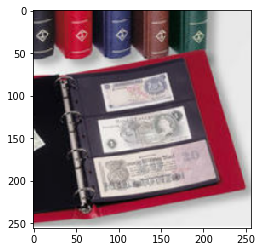

In [21]:
plt.imshow(image)